In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102, CIFAR10, CIFAR100, MNIST, FashionMNIST
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import json
from sklearn.metrics import f1_score, recall_score, accuracy_score

torch.manual_seed(99);

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [2]:
data_dir = '/data'
os.makedirs(data_dir, exist_ok=True)

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transform_gray = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

test_transform_gray = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
dataset_configs = {
    'flowers102': {
        'class': Flowers102,
        'num_classes': 102,
        'colored': True,
        'has_val_split': True
    },
    'cifar10': {
        'class': CIFAR10,
        'num_classes': 10,
        'colored': True,
        'has_val_split': False
    },
    'cifar100': {
        'class': CIFAR100,
        'num_classes': 100,
        'colored': True,
        'has_val_split': False
    },
    'mnist': {
        'class': MNIST,
        'num_classes': 10,
        'colored': False,
        'has_val_split': False
    },
    'fashionmnist': {
        'class': FashionMNIST,
        'num_classes': 10,
        'colored': False,
        'has_val_split': False
    }
}

# Function to load datasets and create DataLoaders
def load_datasets(dataset_name, data_dir, batch_size=32, num_workers=os.cpu_count()):
    config = dataset_configs[dataset_name]
    DatasetClass = config['class']
    colored = config['colored']
    has_val_split = config['has_val_split']
    
    # Select transforms based on whether the dataset is colored
    train_tf = train_transform if colored else train_transform_gray
    test_tf = test_transform if colored else test_transform_gray
    
    if dataset_name == 'flowers102':
        # Flowers102 has predefined splits
        train = DatasetClass(root=data_dir, split='train', download=True, transform=train_tf)
        val = DatasetClass(root=data_dir, split='val', download=True, transform=test_tf)
        test = DatasetClass(root=data_dir, split='test', download=True, transform=test_tf)
    else:
        # Other datasets: use train/test, split test into val/test
        train = DatasetClass(root=data_dir, train=True, download=True, transform=train_tf)
        test = DatasetClass(root=data_dir, train=False, download=True, transform=test_tf)
        
        # Split test set into validation and test (50%/50%)
        test_size = len(test)
        indices = list(range(test_size))
        np.random.shuffle(indices)
        val_size = test_size // 2
        val_idx, test_idx = indices[:val_size], indices[val_size:]
        
        val_sampler = SubsetRandomSampler(val_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        
        val = test  # Same dataset, different sampler
        test = test
    
    # Create DataLoaders
    train_dl = DataLoader(
        train, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    if dataset_name == 'flowers102':
        val_dl = DataLoader(
            val,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
        test_dl = DataLoader(
            test,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
    else:
        val_dl = DataLoader(
            val,
            batch_size=batch_size,
            sampler=val_sampler,
            num_workers=num_workers,
            pin_memory=True
        )
        test_dl = DataLoader(
            test,
            batch_size=batch_size,
            sampler=test_sampler,
            num_workers=num_workers,
            pin_memory=True
        )
    
    print(f'Number of training samples: {len(train)}')
    print(f'Number of validation samples: {len(val_dl.dataset) // 2 if not has_val_split else len(val)}')
    print(f'Number of test samples: {len(test_dl.dataset) // 2 if not has_val_split else len(test)}')
    
    return train_dl, val_dl, test_dl

In [5]:
# batch_size = 32
# num_workers = os.cpu_count()

# train_dl = DataLoader(
#     train, 
#     batch_size=batch_size,
#     shuffle=True, 
#     num_workers=num_workers)
# val_dl = DataLoader(
#     val,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=num_workers
# )
# test_dl = DataLoader(
#     test,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=num_workers
# )

In [6]:
def show_batch(dataloader, dataset_name):
    images, labels = next(iter(dataloader))
    images = images.numpy()
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    axes = axes.flatten()
    
    # Unnormalization based on dataset
    if dataset_name in ['mnist', 'fashionmnist']:
        mean = np.array([0.5])
        std = np.array([0.5])
    else:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
    
    for i, (img, label) in enumerate(zip(images[:32], labels[:32])):
        if img.shape[0] == 1:  # Grayscale
            img = img.squeeze(0)
            axes[i].imshow(img, cmap='gray')
        else:  # Color
            img = img.transpose((1, 2, 0)) * std + mean
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
        axes[i].set_title(f'Class: {label.item()}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, f'batch_visualization_{dataset_name}.png'))
    plt.show()

In [7]:
class Patcher(nn.Module):
    def __init__(self, stride=14, patch_size=14, patch_dim=768, colored=True):
        super(Patcher, self).__init__()
        num_channels = 3 if colored else 1
        self.projection = nn.Conv2d(
            in_channels=num_channels,
            out_channels=patch_dim,
            kernel_size=(patch_size, patch_size),
            stride=stride
        )

    def forward(self, x):
        x = self.projection(x)
        x = x.permute(0, 2, 3, 1).flatten(1, 2)
        return x

class MLPHead(nn.Module):
    def __init__(self, patch_dim=768, num_classes=102):
        super(MLPHead, self).__init__()
        self.projection = nn.Linear(patch_dim, num_classes)

    def forward(self, x):
        logits = self.projection(x[:, 0, :])
        return logits

class Encoder(nn.Module):
    def __init__(self, patch_dim=768, num_heads=12, ffn_dim=3072, dropout=0.1):
        super(Encoder, self).__init__()
        self.num_heads = num_heads
        self.head_dim = patch_dim // num_heads
        assert self.head_dim * num_heads == patch_dim, "patch_dim must be divisible by num_heads"
        
        self.W_q = nn.Linear(patch_dim, patch_dim)
        self.W_k = nn.Linear(patch_dim, patch_dim)
        self.W_v = nn.Linear(patch_dim, patch_dim)
        self.W_o = nn.Linear(patch_dim, patch_dim)
        self.attn_dropout = nn.Dropout(dropout)
        
        self.norm1 = nn.LayerNorm(patch_dim)
        self.norm2 = nn.LayerNorm(patch_dim)
        
        self.residual_dropout = nn.Dropout(dropout)

        self.ffn = nn.Sequential(
            nn.Linear(patch_dim, ffn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_dim, patch_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x1 = self.norm1(x)
        Q = self.W_q(x1)
        K = self.W_k(x1)
        V = self.W_v(x1)

        Q = Q.view(Q.size(0), Q.size(1), self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(K.size(0), K.size(1), self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(V.size(0), V.size(1), self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(x.size(0), x.size(1), -1)
        attn_output = self.W_o(attn_output)
        attn_output = self.residual_dropout(attn_output)

        x = x + attn_output
        x2 = self.norm2(x)

        ffn_output = self.ffn(x2)
        ffn_output = self.residual_dropout(ffn_output)

        x = x + ffn_output
        return x

class ViT(nn.Module):
    def __init__(self, image_size=224, patch_size=14, patch_dim=768, ffn_dim=3072, 
                 num_heads=12, num_layers=12, dropout=0.1, num_classes=102, colored=True):
        super(ViT, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.class_token = nn.Parameter(torch.zeros(1, 1, patch_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, patch_dim))
        
        self.patcher = Patcher(
            stride=patch_size,
            patch_size=patch_size,
            patch_dim=patch_dim,
            colored=colored
        )

        self.encoder_stack = nn.ModuleList([
            Encoder(patch_dim=patch_dim, num_heads=num_heads, ffn_dim=ffn_dim, dropout=dropout)
            for _ in range(num_layers)
        ])

        self.mlp_head = MLPHead(patch_dim=patch_dim, num_classes=num_classes)
    
    def forward(self, x):
        x = self.patcher(x)
        batch_size, _, _ = x.shape
        class_token = self.class_token.repeat(batch_size, 1, 1)
        patch_embedding = torch.cat([class_token, x], dim=1)
        x = patch_embedding + self.pos_embedding

        for layer in self.encoder_stack:
            x = layer(x)

        logits = self.mlp_head(x)
        return logits

# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Parameter):
        nn.init.normal_(m, std=0.02)

# Metric computation
def compute_metrics(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, recall

# Training loop
def train_model(model, train_loader, val_loader, num_epochs=50, lr=3e-4, device='cuda', dataset_name='flowers102'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    model = model.to(device)
    
    metrics = {
        'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_recall': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_recall': []
    }
    
    best_val_acc = 0.0
    best_model_path = os.path.join(data_dir, f'best_vit_{dataset_name}.pth')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')
        
        val_loss, val_acc, val_f1, val_recall = compute_metrics(model, val_loader, criterion, device)
        
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['train_f1'].append(train_f1)
        metrics['train_recall'].append(train_recall)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        metrics['val_f1'].append(val_f1)
        metrics['val_recall'].append(val_recall)
        
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, Recall: {train_recall:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, Recall: {val_recall:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f'Saved best model with Val Acc: {best_val_acc:.4f}')
    
    return metrics, best_model_path

# Test set evaluation
def evaluate_test_set(model, test_loader, criterion, device, best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    model = model.to(device)
    
    test_loss, test_acc, test_f1, test_recall = compute_metrics(model, test_loader, criterion, device)
    
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, Recall: {test_recall:.4f}')
    
    return test_loss, test_acc, test_f1, test_recall

# Plot metrics
def plot_metrics(metrics, num_epochs, dataset_name):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['train_acc'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_acc'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['train_f1'], label='Train F1')
    plt.plot(epochs, metrics['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, f'training_metrics_{dataset_name}.png'))
    plt.show()

In [8]:
def main(dataset_name):
    config = dataset_configs[dataset_name]
    num_epochs = 300
    lr = 3e-4
    batch_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load datasets
    print(f"Loading {dataset_name} dataset...")
    train_dl, val_dl, test_dl = load_datasets(dataset_name, data_dir, batch_size=batch_size)
    
    # Visualize a batch
    print("Visualizing a batch of training images...")
    show_batch(train_dl, dataset_name)
    
    # Initialize model
    model = ViT(
        image_size=224,
        patch_size=14,
        patch_dim=768,
        ffn_dim=3072,
        num_heads=12,
        num_layers=12,
        dropout=0.1,
        num_classes=config['num_classes'],
        colored=config['colored']
    )
    
    model.apply(init_weights)
    
    # Train model
    print("Starting training...")
    metrics, best_model_path = train_model(model, train_dl, val_dl, num_epochs=num_epochs, 
                                          lr=lr, device=device, dataset_name=dataset_name)
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_loss, test_acc, test_f1, test_recall = evaluate_test_set(model, test_dl, nn.CrossEntropyLoss(), 
                                                                 device, best_model_path)
    
    # Plot metrics
    print("Plotting metrics...")
    plot_metrics(metrics, num_epochs, dataset_name)
    
    # Save metrics
    with open(os.path.join(data_dir, f'metrics_{dataset_name}.json'), 'w') as f:
        json.dump(metrics, f)

Loading flowers102 dataset...


100%|██████████| 345M/345M [00:13<00:00, 26.1MB/s] 


Extracting /data/flowers-102/102flowers.tgz to /data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 877kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 24.2MB/s]

Number of training samples: 1020
Number of validation samples: 1020
Number of test samples: 6149
Visualizing a batch of training images...


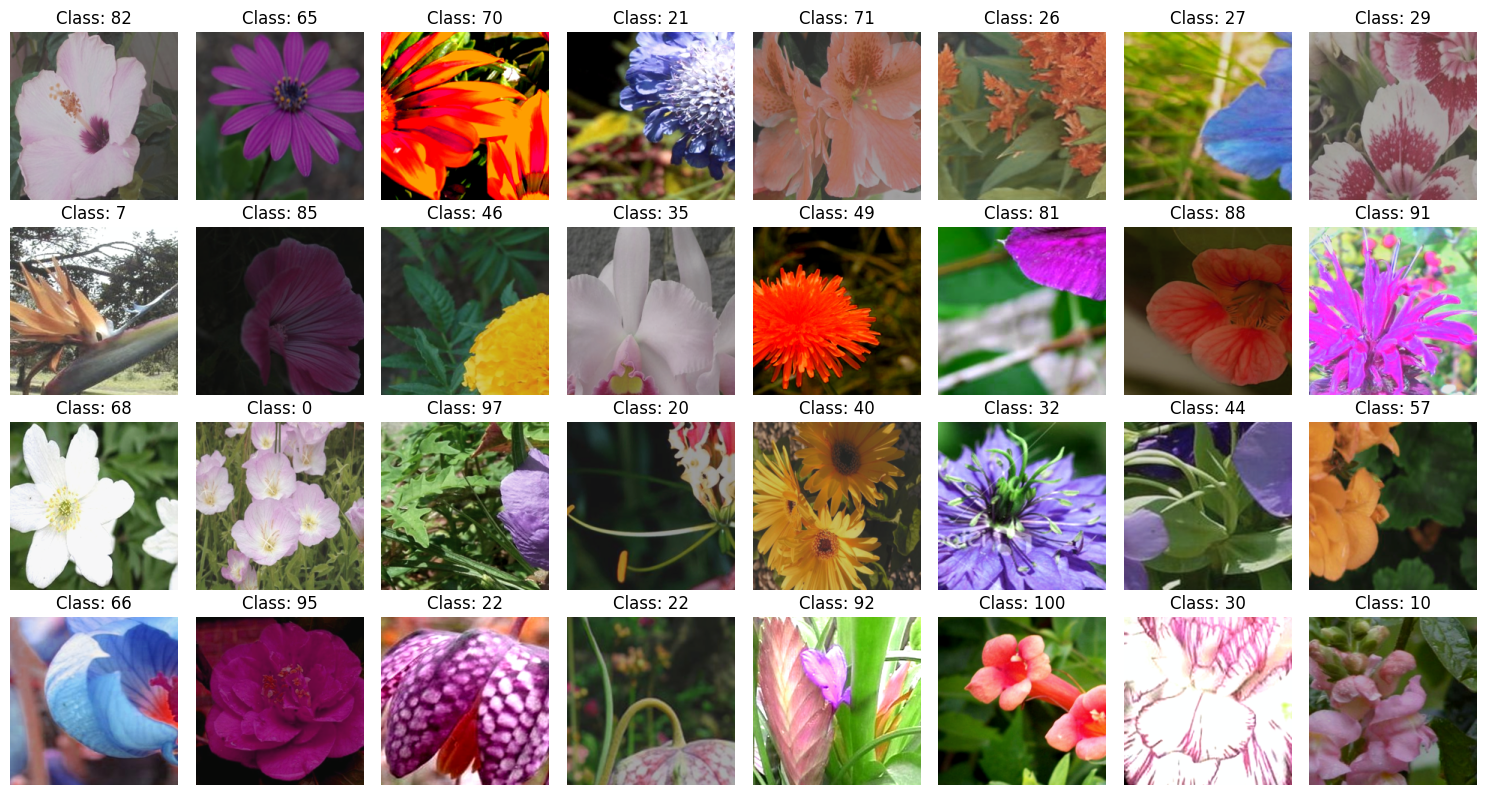

Starting training...


Epoch 1/5: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Epoch [1/5]
Train Loss: 24.3340, Acc: 0.0118, F1: 0.0115, Recall: 0.0118
Val Loss: 27.9113, Acc: 0.0108, F1: 0.0053, Recall: 0.0108
Saved best model with Val Acc: 0.0108


Epoch 2/5: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


Epoch [2/5]
Train Loss: 25.3172, Acc: 0.0196, F1: 0.0195, Recall: 0.0196
Val Loss: 19.9646, Acc: 0.0235, F1: 0.0065, Recall: 0.0235
Saved best model with Val Acc: 0.0235


Epoch 3/5: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


Epoch [3/5]
Train Loss: 18.4776, Acc: 0.0216, F1: 0.0199, Recall: 0.0216
Val Loss: 16.6854, Acc: 0.0245, F1: 0.0043, Recall: 0.0245
Saved best model with Val Acc: 0.0245


Epoch 4/5:   9%|▉         | 3/32 [00:03<00:27,  1.05it/s]

In [ ]:
if __name__ == '__main__':
    main('flowers102')